In [3]:
from cgru import CGRU

from itertools import chain
from pathlib import Path
import torch
from torch import nn
from torch.utils.data.dataloader import DataLoader

from tokenizers import ByteLevelBPETokenizer

import numpy as np

from languages_list import Languages

from gh_dataset import MixedDataset, Subset
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import pickle

from sklearn.model_selection import train_test_split
from scipy.sparse import csr_array, load_npz, save_npz

tokenizer = ByteLevelBPETokenizer("./artifacts/tokenizer-vocab.json", "./artifacts/tokenizer-merges.txt")

with open("artifacts/folds.pkl", "rb") as file:
   fold0, fold1, fold2, fold3 = pickle.load(file)

In [2]:
dataset = MixedDataset(tokenize=True, subsample_lines=True)

In [42]:
gru = CGRU()

val_data = Subset(dataset, fold0)
test_data = Subset(dataset, fold2)

class Batch(dict):
    def __init__(self, dict):
        self.update(dict)

    def to(self, device):
        items = []
        for k, v in self.items():
            if isinstance(v, torch.Tensor):
                items.append((k, v.to(device)))

        for k, v in items:
            self[k] = v

        return self

pad_token = tokenizer.token_to_id("<pad>")
max_seq_len = 8192

def collate_fn(batch):
    ids, labels = zip(*batch)
    
    max_len = max(len(i) for i in ids)
    max_len = min(max_len, max_seq_len)
    max_len = (max_len + 15) // 16 * 16

    ids = torch.tensor([
        i[:max_len] + [pad_token for j in range(max_len - len(i))]
        for i in ids
    ])
    mask = ids != pad_token
    last_element = mask.sum(dim=1) - 1
    labels = torch.tensor([label.value - 1 for label in labels])

    return Batch({
        "ids": ids,
        "mask": mask,
        "last_element": last_element,
        "labels": labels,
    })

val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(val_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [9]:
num_rows = len(val_data)
num_cols = 2**15

data = []
indices = []
indptr = [0]

states = np.empty((len(val_data), 96))
predictions = []
labels = []

for i, (tokens, label) in enumerate(tqdm(val_data)):
    tokens = tokens[:8192]

    prediction, last_state = gru(tokens)
    states[i, ...] = last_state.copy()
    predictions.append(prediction)
    labels.append(label.value - 1)

    ids, counts = np.unique(tokens, return_counts=True)
    data.extend(counts)
    indices.extend(ids)
    indptr.append(indptr[-1] + len(ids))

predictions = np.array(predictions)
labels = np.array(labels)

sparse_data_matrix = csr_array((data, indices, indptr), shape=(num_rows, num_cols))
save_npz("fold0_tf_gru_aligned.npz", sparse_data_matrix)
np.save("fold0_gru_states.npy", states)

np.save("fold0_gru_predictions.npy", predictions)
np.save("fold0_labels.npy", labels)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [43]:
num_rows = len(test_data)
num_cols = 2**15

data = []
indices = []
indptr = [0]

states_test = np.empty((len(test_data), 96))
predictions = []
labels = []

for i, (tokens, label) in enumerate(tqdm(test_data)):
    tokens = tokens[:8192]

    prediction, last_state = gru(tokens)
    states_test[i, ...] = last_state.copy()
    predictions.append(prediction)
    labels.append(label.value - 1)

    ids, counts = np.unique(tokens, return_counts=True)
    data.extend(counts)
    indices.extend(ids)
    indptr.append(indptr[-1] + len(ids))

predictions = np.array(predictions)
labels = np.array(labels)

sparse_data_matrix_test = csr_array((data, indices, indptr), shape=(num_rows, num_cols))
save_npz("fold2_tf_gru_aligned.npz", sparse_data_matrix_test)
np.save("fold2_gru_states.npy", states_test)

np.save("fold2_gru_predictions.npy", predictions)
np.save("fold2_labels.npy", labels)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [44]:
predictions

array([70, 64,  0, ..., 98, 99, 95])

In [45]:
(predictions == labels).mean()

0.93744

In [46]:
def normalize_sparse_mat(x):
    row_sum = x.sum(axis=1)
    x.data = x.data / np.repeat(row_sum, np.diff(x.indptr))
    return x

# train_data = normalize_sparse_mat(train_data)
# sparse_data_matrix_test = normalize_sparse_mat(sparse_data_matrix_test)

sparse_data_matrix_test = normalize_sparse_mat(sparse_data_matrix_test)

In [47]:
states_sparse_test = csr_array(states_test)

In [48]:
from scipy.sparse import hstack
tf_and_states_test = hstack((sparse_data_matrix_test, states_sparse_test))

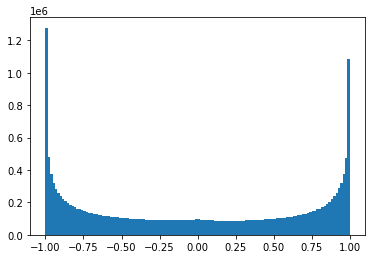

In [37]:
plt.hist(states_sparse.data, bins=128);

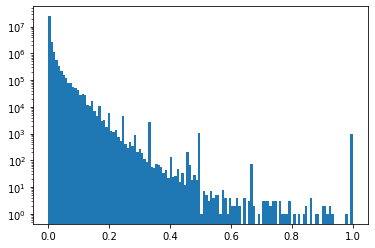

In [36]:
plt.hist(sparse_data_matrix.data, bins=128)
plt.yscale("log")

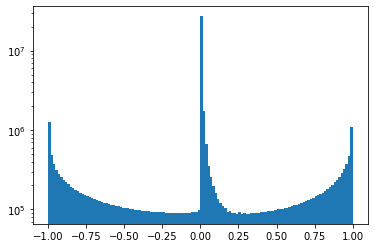

In [39]:
plt.hist(tf_and_states.data, bins=128)
plt.yscale("log")

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=10, fit_intercept=False, verbose=1)
svc.fit(tf_and_states, labels)
# np.save("svc_merger.npy", svc, allow_pickle=True)
import pickle
with open("svc_merger.pkl", "wb") as file:
    pickle.dump(svc, file)

In [50]:
final_predictions = svc.predict(tf_and_states_test)

In [51]:
(final_predictions == labels).mean()

0.939635

: 

In [12]:


for i, (text, label) in enumerate(tqdm(val_data)):
    prediction, last_state = gru(text)
    states[i, ...] = last_state
    predictions.append(prediction)
    labels.append(label.value - 1)

np.save("fold0_states.npy", states)
predictions = np.array(predictions)
labels = np.array(labels)

(predictions == labels).mean()

  0%|          | 0/200000 [00:00<?, ?it/s]